# 🧠 Intro to A.I., Machine & Deep learning in the sciences
### Kari K. Barry : Software Engineer 
#### Data Science and Systems Integration @ National Synchrotron Light Source II

# 💪 How to prepare your data for effective training and instancing

"*The quality of your model and its outputs are only as good as the data you put in it*"
- Ancient proverb

# Uniformity
1. Data (ideally) must be of the same shape, meaning the number of rows/columns are roughly the same
2. Data must be labeled consistently 

### The following is a good example of how to label your measurements

![Good encoding](images/good_encoding.png)
Notice how the same intensities are measured in both spreadsheets? Also the names of the measurements columns are the same unit.

### Conversely, this is a bad example

![Bad encoding](images/bad_encoding.png)

# Encodings
Computers intrinsically understand NUMBERS, whereas we are working with complex measurements that carry nuance. We have to *encode* that nuance into the numbers using principals like *cardinality* and *dimensionality*.

- One Hot Encoding: Convert values to binary operators, 0 and 1 can be used to indicate if something *is* or *isn't* in a category. This works well with poorly labeled data but can create tables that have too many bespoke features. Generally this should be avoided unless absolutely necessary.

![One Hot Encoding](images/ohe.jpg)
- **Label Encoding** : (This is what we will be doing) Create features based off a constrained list of properties and assign those properties numbers. The numbers (e.g. 1, 2, 3) have meanings that map back to labels.

![Label Encoding](images/le.png)

# ❓️ What is Machine Learning? How is it different from Deep Learning & A.I.
Machine leaning, like an advanced form of statistics, helps us make sense of our data.
Deep learning and A.I. are machine learning principals scaled up to deal with a *massive* volume of data, instituting additional controls like *weights* and *biases* to influence the outcome. 

However, we don't have access to that much data in this experiment. This is a good thing, we can use the *Scikit Learn* python library which can operate on the data within the registers of our CPU to form a comprehensive model. Deep learning often requires parallel computers like GPUs to process such large and complex volumes of data with libraries like NVIDIA *CUDA*.

Let's say we have a bunch of measurements of one class of thing or another, plotting our data out allows us to see the relationship of measurements we already have. However, what if there's a new datapoint and we need to figure out how it should be classified? Where it should go on the plot? Traditional approaches have this problem.
![Instance based learning](images/instance_learn.png)

If we apply machine learning principals to cluster results together based on *features*, this allows us to build a model which can be represented on the plot with either a line or a subset. Now we can more accurately place new instances within the plot and make predictions about what class they will belong to.
![Model based learning](images/model_learn.png)

### Models & algorithms
These work through *algorithms* which sort the data a specific way to form the model.
For the sake of simplicity, we're going to present two algorithms and use one of them.
- *K-nearest Neighbor* : When analyzing the plot, if instances with similar features are naturally **grouped together** in *clusters*, K-Nearest Neighbor can help further group new instances together and create distinct regions representing classifications.
- *Linear and logistic regression* : If instances appear to be divisible into classifications by a **straight line** on the plot, regressors are a good choice for mapping features. A linear or logistic series of values is descended to find and create classifications amongst similar instances.

There are of course, many other algorithms available for different use cases. Which of these two should we use for our data?

(The only way to find out will be to set up a python environment and generate a plot)

In [53]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [30]:
# Load the combined dataset
combined_df = pd.read_csv("data/combined.csv")

# Step 2: Prepare the Data
# Assume first column is wavelength, others are sample types (flour, corn starch, etc.)
wavelengths = combined_df.iloc[:, 0]
sample_data = combined_df.iloc[:, 1:]
sample_labels = sample_data.columns

In [31]:
# Transpose so each row is one sample, and columns are wavelengths
X = sample_data.T
X.columns = wavelengths
X.index.name = 'Sample'

# Create label vector from index
labels = X.index
X = X.reset_index(drop=True)

# Step 3: Normalize the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

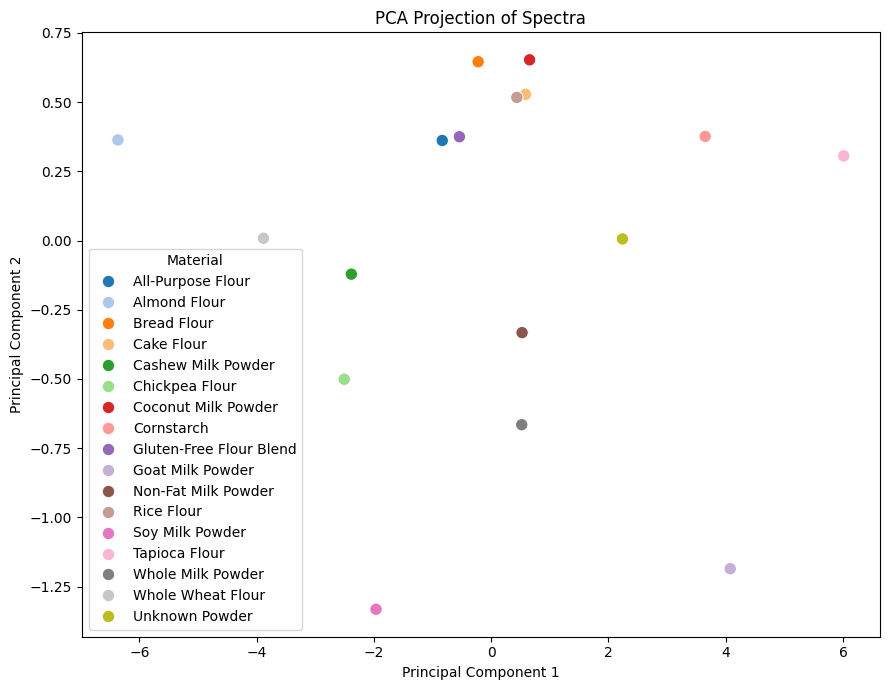

In [ ]:
# Step 4: Reduce Dimensions for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a PCA projection which can show us a basic positioning of similar materials by spectra
plt.figure(figsize=(9, 7))

# Draw a red shape to reveal what kind of modeling would be best fit
# x_min, x_max = plt.xlim()
# y_mean = X_pca[:, 1].mean()
# slope = 0.25

# x_vals = np.array([x_min + 5 , x_max - 5])
# y_vals = y_mean + slope * (x_vals - x_min)
# line, = plt.plot(x_vals, y_vals, 'r-', linewidth=2, label='Modeling Boundary', zorder=10)

palette = sns.color_palette("tab20", n_colors=17)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette=palette, s=80, zorder=0)
plt.title("PCA Projection of Spectra")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Material", loc="best")
plt.tight_layout()
plt.show()


The generated plot normalizes the intensity values of our measurements and embeds them as features of each sample type. This allows us to plot them on a scale relative to each other. Upon closer inspection what sort of trend do you notice visually within the plot?

In [34]:
# Step 5: Fit a Logistic Regression Model (linear classifier) which we can use to make predictions
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, labels)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Training Accuracy: 0.82


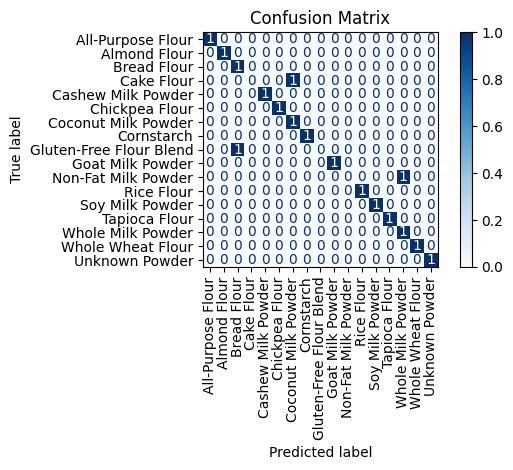

In [19]:
# Evaluate on same data (for demo purposes)
pred_labels = model.predict(X_scaled)
accuracy = accuracy_score(labels, pred_labels)
print(f"Training Accuracy: {accuracy:.2f}")

cm = confusion_matrix(labels, pred_labels, labels=labels.unique())
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.unique()).plot(cmap="Blues", xticks_rotation=90)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [20]:
# Step 6: Load Mystery Sample and Predict
mystery_df = pd.read_csv("data/MysteryPowder.csv")

# Make sure the sample is in the same format (just the intensity values)
mystery_sample = mystery_df.iloc[:, 1].values.reshape(1, -1)  # skip the wavelength column
mystery_scaled = scaler.transform(mystery_sample)


In [21]:
mystery_pred = model.predict(mystery_scaled)

print(f"\n🔍 The mystery sample is predicted to be: {mystery_pred[0]}")


🔍 The mystery sample is predicted to be: Tapioca Flour


In [22]:
# 🎓 Step 8: Analyze Student Samples
# Assume all student files are in the same directory and follow the format 'StudentName-Material.csv'
student_files = glob.glob("data/students/*.csv")
student_data = []
student_metadata = []

for file in student_files:
    filename = os.path.basename(file)
    
    try:
        name, material = filename.replace(".csv", "").replace("_", " ").split("-", 1)
        df = pd.read_csv(file)
        sample_values = df.iloc[:, 1].values  # assume second column is values
        student_data.append(sample_values)
        student_metadata.append({"Student": name, "Material": material})
    except Exception as e:
        print(f"Could not read {filename}: {e}")

In [23]:
student_df = pd.DataFrame(student_data)
student_meta_df = pd.DataFrame(student_metadata)

# Normalize and reduce dimensions
student_scaled = scaler.transform(student_df)
student_pca = pca.transform(student_scaled)


In [24]:
# Predict with trained model
student_predictions = model.predict(student_scaled)
student_meta_df["Predicted"] = student_predictions

In [25]:
# Show prediction and error comparison
student_meta_df["Correct"] = student_meta_df["Material"] == student_meta_df["Predicted"]
print("\nStudent Sample Predictions:")
print(student_meta_df)


Student Sample Predictions:
  Student     Material     Predicted  Correct
0     Jax  Bread Flour  Almond Flour    False
1    Luna  Bread Flour  Almond Flour    False
2     Rin   Cornstarch    Rice Flour    False
3     Rin  Bread Flour  Almond Flour    False
4   Fleki   Cornstarch    Cornstarch     True
5    Luna   Cornstarch    Rice Flour    False
6     Jax   Cornstarch    Rice Flour    False
7   Fleki  Bread Flour   Bread Flour     True


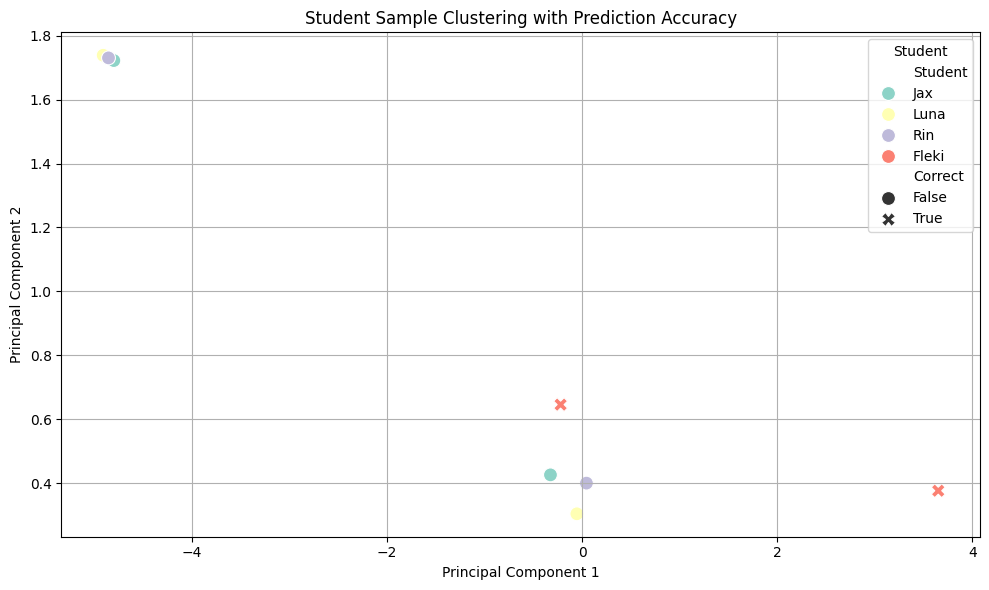

In [26]:
# Visualize clustering by student and prediction
plt.figure(figsize=(10, 6))
sns.scatterplot(x=student_pca[:, 0], y=student_pca[:, 1], hue=student_meta_df["Student"], style=student_meta_df["Correct"], palette="Set3", s=100)
plt.title("Student Sample Clustering with Prediction Accuracy")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Student")
plt.grid(True)
plt.tight_layout()
plt.show()
